In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f'The most recent date is {most_recent_date[0]}')

The most recent date is 2017-08-23


The start date for the last year of data is 2016-08-24


Text(0.5, 0, '')

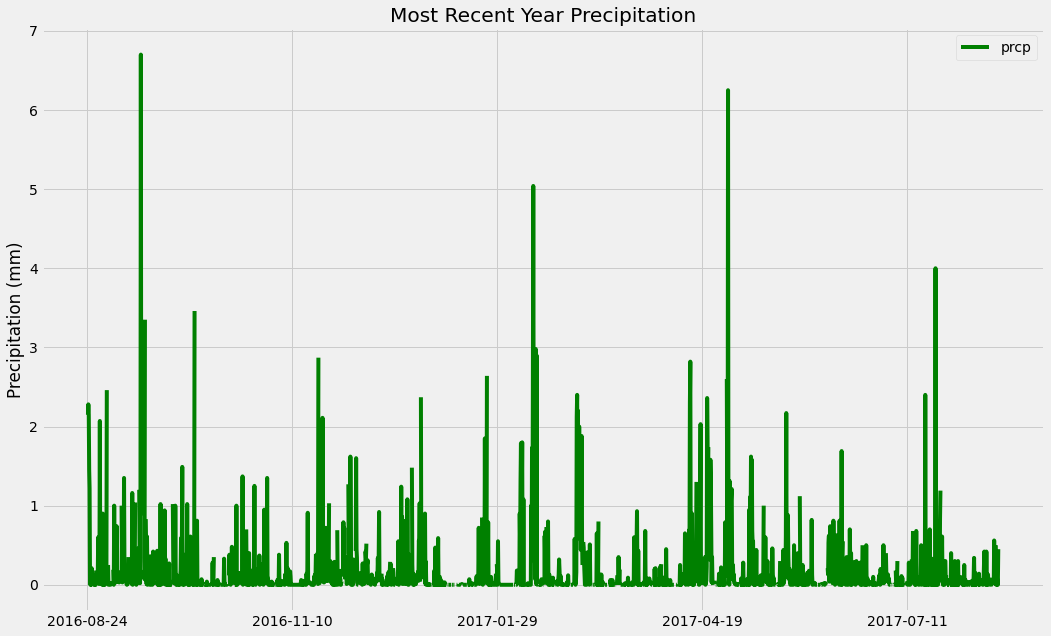

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
lastyear_startdate = (dt.datetime.strptime(most_recent_date[0],'%Y-%m-%d') - dt.timedelta(days=364)).strftime('%Y-%m-%d')
print(f'The start date for the last year of data is {lastyear_startdate}')

# Perform a query to retrieve the data and precipitation scores. Save the query results as a Pandas DataFrame
mostrecentyear_date_prec = pd.DataFrame(session.query(measurement.date, measurement.prcp).filter(measurement.date >=lastyear_startdate).all())

mostrecentyear_date_prec.head()
# Set the index to the date column

mostrecentyear_date_prec.set_index('date', inplace = True)

# Sort the dataframe by date
mostrecentyear_date_prec = mostrecentyear_date_prec.sort_index()
mostrecentyear_date_prec.head(5)


# Use Pandas Plotting with Matplotlib to plot the data
mostrecentyear_date_prec.plot(color="green", figsize=(16, 10))
plt.title("Most Recent Year Precipitation")
plt.ylabel("Precipitation (mm)")
plt.xlabel("")


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summ_stats = mostrecentyear_date_prec["prcp"].describe()
Summ_stats_df = pd.DataFrame(summ_stats)
summ_stats.head(10)


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station.station).count()
print(f'The total number of stations is {total_stations}')



The total number of stations is 9


In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_sessions = session.query(measurement.station, func.count(measurement.date)).group_by(measurement.station).\
    order_by(func.count(measurement.date).desc()).all()
                               
most_active_station = session.query(measurement.station, func.count(measurement.date)).group_by(measurement.station).\
    order_by(func.count(measurement.date).desc()).first()


most_active_station_df = pd.DataFrame(most_active_station)

most_active_station_df.head()
most_active_station_id = most_active_station[0]
most_active_station_id

'USC00519281'

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_temp_stats = session.query(measurement.station,func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs))\
                            .filter(measurement.station == most_active_station_id).all()


most_active_temp_stats_min = session.query(func.min(measurement.tobs))\
                            .filter(measurement.station == most_active_station_id).scalar()
most_active_temp_stats_max = session.query(func.max(measurement.tobs))\
                            .filter(measurement.station == most_active_station_id).scalar()
most_active_temp_stats_avg = session.query(func.avg(measurement.tobs))\
                            .filter(measurement.station == most_active_station_id).scalar()

print(f'The most active station is station {most_active_station_id}.')
print(f'The minimum temperature recorded at station {most_active_station_id} is {most_active_temp_stats_min}.')
print(f'The maximum temperature recorded at station {most_active_station_id} is {most_active_temp_stats_max}.')
print(f'The average temperature recorded at station {most_active_station_id} is {most_active_temp_stats_avg}.')


The most active station is station USC00519281.
The minimum temperature recorded at station USC00519281 is 54.0.
The maximum temperature recorded at station USC00519281 is 85.0.
The average temperature recorded at station USC00519281 is 71.66378066378067.


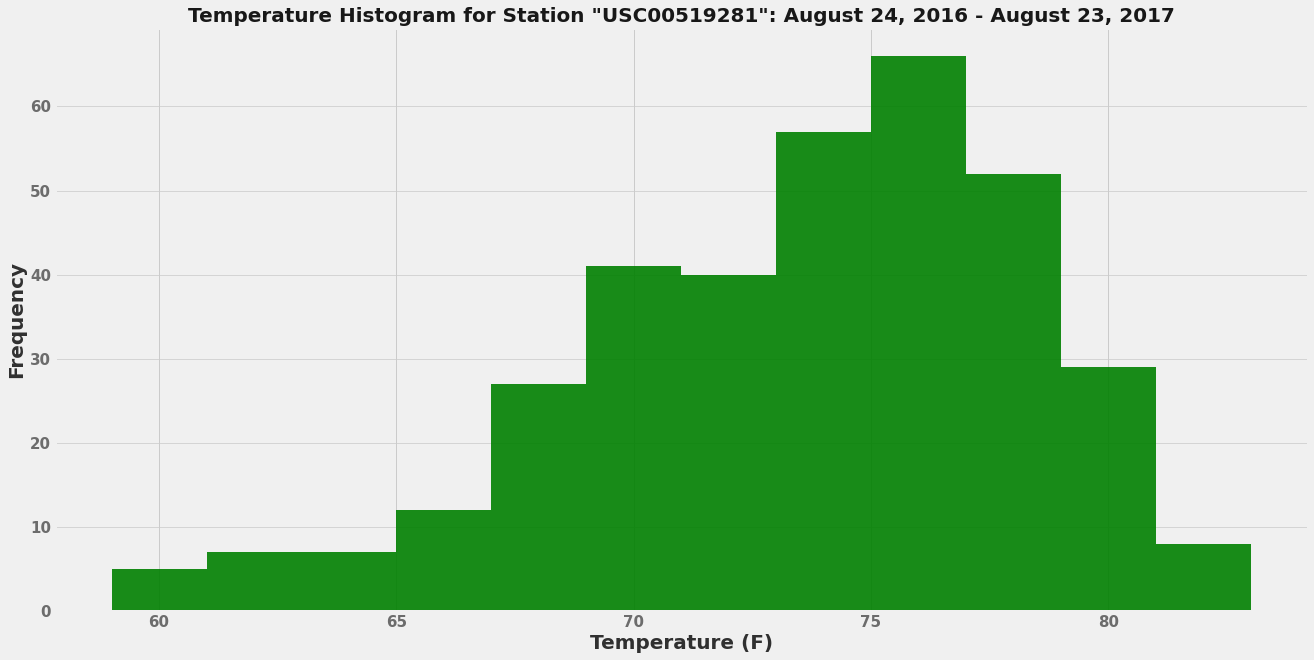

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_twelve_months_temp = session.query(measurement.tobs).filter(measurement.station==most_active_station_id, measurement.date>=lastyear_startdate).all()

last_twelve_months_temp_df = pd.DataFrame(last_twelve_months_temp)
last_twelve_months_temp_df.head()

plt.figure(figsize=[20,10])
temp_histogram = plt.hist(x= last_twelve_months_temp_df, bins=12, 
                           color='green',alpha=0.9)
plt.grid(axis='y', alpha=0.75);
plt.xlabel('Temperature (F)',fontweight="bold", alpha=0.8, fontsize=20);
plt.ylabel('Frequency',fontweight="bold", alpha=0.8, fontsize=20);
plt.xticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.yticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.title('Temperature Histogram for Station "USC00519281": August 24, 2016 - August 23, 2017',
          fontweight="bold", alpha=0.9, fontsize=20);

# Close session

In [23]:
# Close Session
session.close()